# Machine Learning: Assignment 1

In [1]:
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from sklearn.preprocessing import OneHotEncoder

# 1. Data Import, leansing Setup and helper functions

In [2]:
class Data():
    def dataAllocation(self,path):
        # df = pd.read_csv(path)
        # x_data = df.iloc[:, :-1]
        # y_data = df.iloc[:, -1 ]
        # return x_data,y_data
        X, y = make_classification(n_samples=2000, n_features=20, n_informative=10, n_redundant=0, random_state=rs)
        return X, y
    def trainSets(self,x_data,y_data):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = rs, shuffle = True)
        return x_train, x_test, y_train, y_test

data = 'data/pima-indians-diabetes.csv'
rs = 614
dataset = Data()
x_data,y_data = dataset.dataAllocation(data)
x_train, x_test, y_train, y_test = dataset.trainSets(x_data,y_data)
# print("Heatmap for Features")
# data_corr = sns.heatmap(pd.DataFrame(x_train).corr(), cmap='Blues')

# 2. Decision Tree Classifier

In [3]:
class DTClassifier():

    def trainTest(self,x_train,x_test, y_train):
        df = []
        for i in range(16):
            for j in range(20):
                dt_clf = DecisionTreeClassifier(max_depth=i+1, min_samples_leaf=j+1)
                dt_clf.fit(x_train, y_train)
                
                y_predict_train = dt_clf.predict(x_train)
                y_predict_test = dt_clf.predict(x_test)
                df.append([i+1, j+1, "Train", f1_score(y_train, y_predict_train)])
                df.append([i+1, j+1, "Test", f1_score(y_test, y_predict_test)])

        return pd.DataFrame(df, columns=["Depth", "Leaf Size", "Sample Type", "F1 Score" ])
    
    def hyperParameterTuning(self,x_train,y_train):
        param_grid = {'max_depth': range(1, 21), 'min_samples_leaf': range(1, 20)}
        tuned = GridSearchCV(estimator = DecisionTreeClassifier(random_state = rs), param_grid = param_grid, cv=10)
        tuned.fit(x_train, y_train)
        print(tuned.best_params_)
        return tuned.best_score_, tuned.best_params_

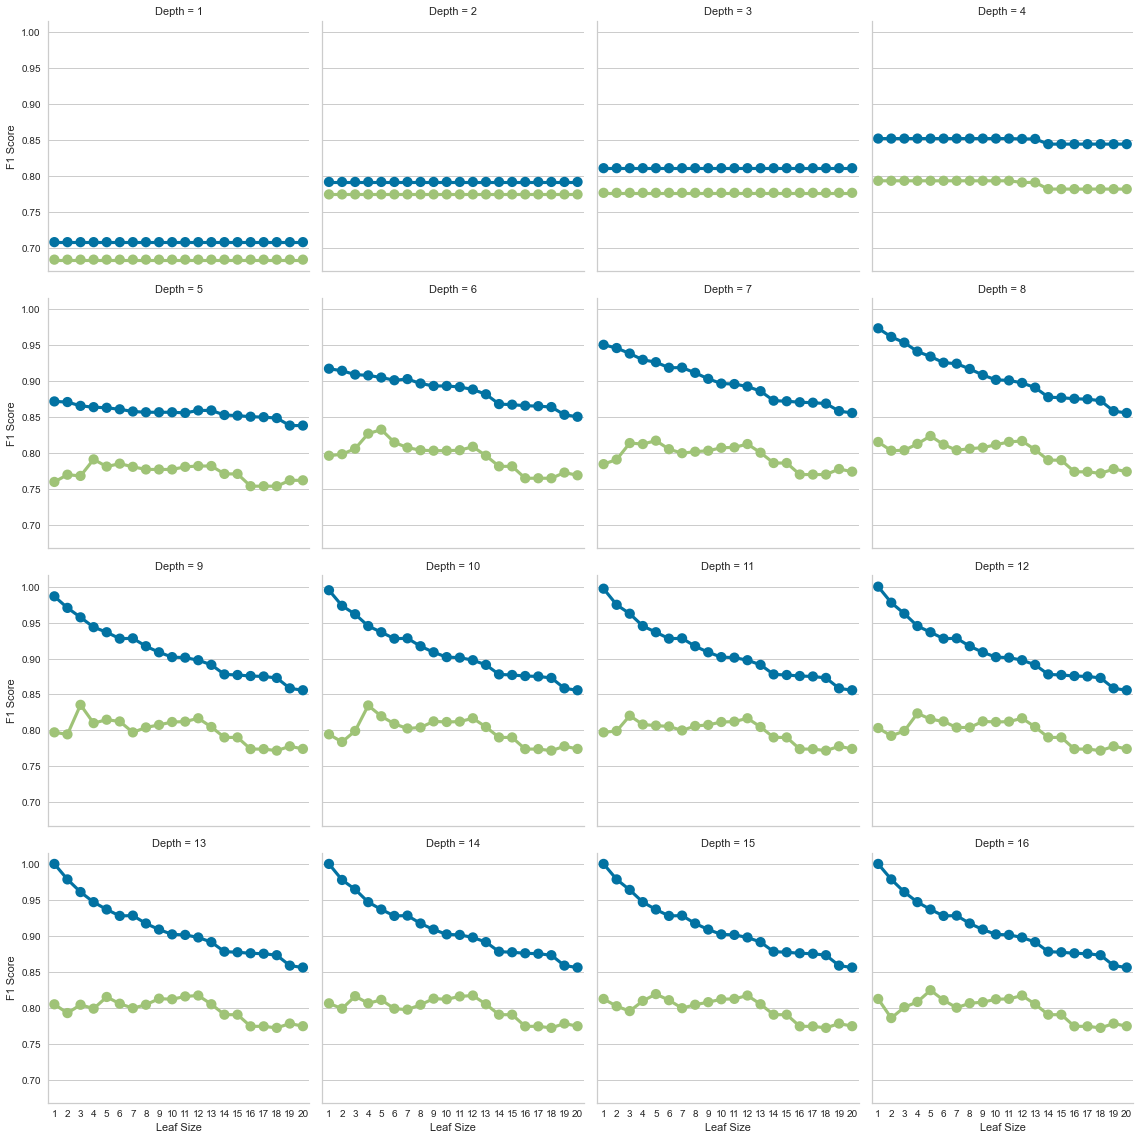

In [4]:
dt = DTClassifier()
df = dt.trainTest(x_train, x_test, y_train)
g = sns.FacetGrid(df, hue="Sample Type", col="Depth", height=4, col_wrap=4)
g.map(sns.pointplot, "Leaf Size", "F1 Score" )

In [5]:
best_score, best_params = dt.hyperParameterTuning(x_train,y_train)
print(best_score)

{'max_depth': 10, 'min_samples_leaf': 5}
0.8150000000000001


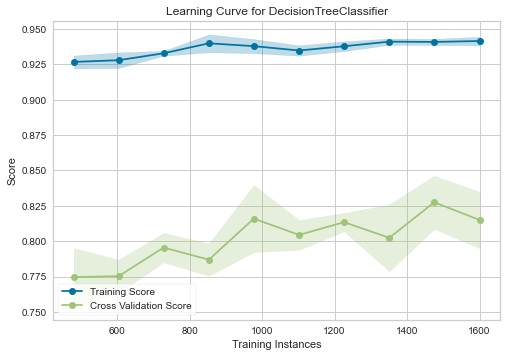

In [6]:
dt_tuned = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=rs)

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    dt_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  

# 3. Support Vector Machine

In [7]:
class SupportVectorMachine():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test
    
    def trainTest(self,scaled_x_train,scaled_x_test, y_train, y_test):
        cs = [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]]
        df = []
        for c in cs:
            for k in ["linear", "sigmoid"]:
                model = SVC(kernel = k, C=c)
                model.fit(scaled_x_train,y_train)
                y_predict_train = model.predict(scaled_x_train)
                y_predict_test = model.predict(scaled_x_test)
                df.append([k, c, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Kernel", "C", "Accuracy"])
        
    def hyperParameterTuning(self,scaled_x_train, y_train):
        param_grid = {'C': [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]],  
            'kernel': ["linear", "sigmoid"]}  
        svm_tune = SVC(gamma = "auto")
        svm_cv = GridSearchCV(estimator = svm_tune, param_grid = param_grid, n_jobs=5, return_train_score=True)
        svm_cv.fit(scaled_x_train, y_train)
        best_score = svm_cv.best_score_
        return best_score, svm_cv.best_params_

In [8]:
svm = SupportVectorMachine()
scaled_x_train, scaled_x_test = svm.dataPreProcess(x_train,x_test)
df = svm.trainTest(scaled_x_train,scaled_x_test, y_train, y_test)
best_score, best_params = svm.hyperParameterTuning(scaled_x_train, y_train)
print(best_score, best_params)

0.8614285714285714 {'C': 0.01, 'kernel': 'linear'}


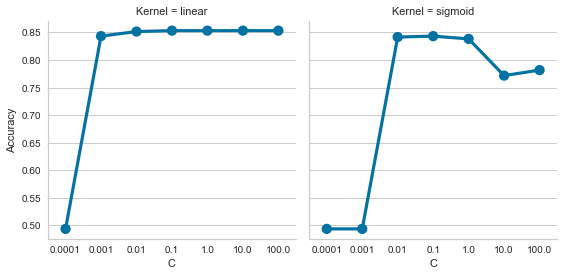

In [9]:
g = sns.FacetGrid(df, col="Kernel",  height=4)
g.map(sns.pointplot, "C", "Accuracy")

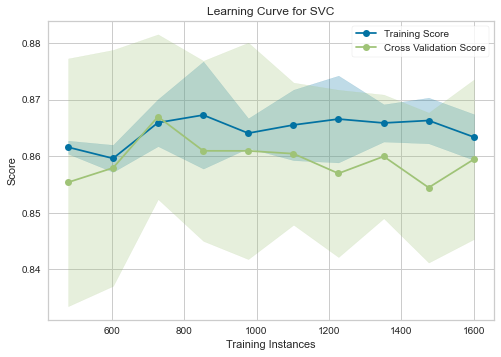

In [10]:
dt_tuned = SVC(kernel=best_params['kernel'], C=best_params['C'])

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    dt_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  

# 4. KNN

In [11]:
class KNN():
    def testTrain(self,x_train,x_test, y_train):
        df = []
        for i in range(20):
            model = KNeighborsClassifier(n_neighbors= i+1)
            model.fit(x_train, y_train)
            y_predict_test = model.predict(x_test)
            df.append([i+1, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns= ["Neighbors", "Accuracy"])
    
    def hyperParameterTuning(self,x_train,y_train):
        tuned = GridSearchCV(KNeighborsClassifier(), {"n_neighbors" : range(1, 21)})
        tuned.fit(x_train, y_train)
        return tuned.best_score_, tuned.best_params_
       



In [12]:
knn = KNN()
df = knn.testTrain(x_train,x_test, y_train)
best_score, best_params = knn.hyperParameterTuning(x_train,y_train)
print(best_score, best_params)

0.9242857142857142 {'n_neighbors': 10}


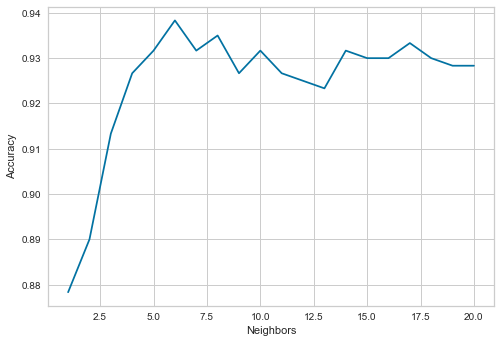

In [13]:
sns.lineplot(data=df, x="Neighbors", y="Accuracy")

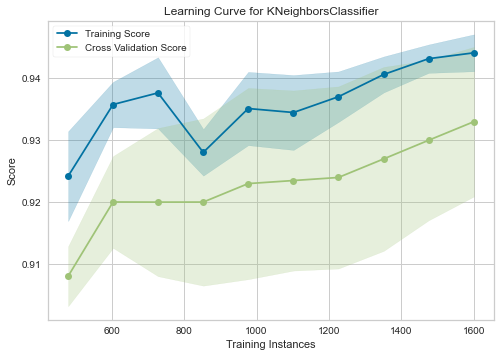

In [14]:
knn_tuned = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    knn_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  

# 5. Neural Network

In [15]:
np.linspace(1,150,30).astype('int')

array([  1,   6,  11,  16,  21,  26,  31,  36,  42,  47,  52,  57,  62,
        67,  72,  78,  83,  88,  93,  98, 103, 108, 114, 119, 124, 129,
       134, 139, 144, 150])

In [16]:
class NN():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test

    def trainTest(self,scaled_x_train,scaled_x_test, y_train, y_test):
        df = []
        for i in [0.01, 0.02, 0.04, 0.08, 0.1]:
            model = MLPClassifier(max_iter=300, learning_rate_init=i)
            model.fit(scaled_x_train,y_train)
            y_predict_train = model.predict(scaled_x_train)
            y_predict_test = model.predict(scaled_x_test)
            df.append([i, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Learning Rate", "Accuracy"])
        
    def hyperParameterTuning(self,scaled_x_train, y_train):
        param_grid = {
            'hidden_layer_sizes': [x**2 for x in range(2, 11)],
            'learning_rate_init': [0.01, 0.02, 0.04, 0.08, 0.1],
        }
        tuned = GridSearchCV(MLPClassifier(max_iter=300), param_grid = param_grid, cv=10)
        tuned.fit(scaled_x_train, y_train)
        return tuned.best_score_, tuned.best_params_


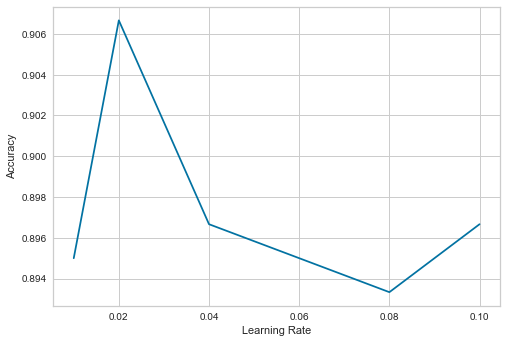

In [17]:
nn = NN()
scaled_x_train, scaled_x_test = nn.dataPreProcess(x_train,x_test)
df = nn.trainTest(scaled_x_train,scaled_x_test, y_train, y_test)
sns.lineplot(data=df, x="Learning Rate", y="Accuracy")


In [18]:
best_score, best_params = nn.hyperParameterTuning(scaled_x_train, y_train)
print(best_score, best_params)

0.9099999999999999 {'hidden_layer_sizes': 81, 'learning_rate_init': 0.04}


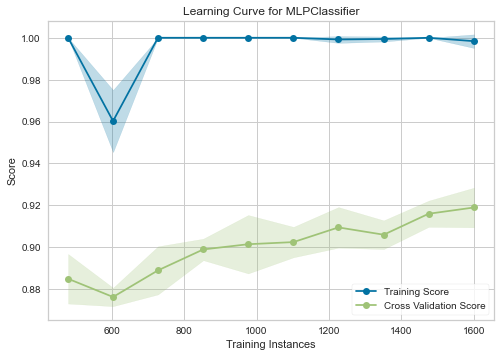

In [19]:
boost_tuned = MLPClassifier(max_iter=300, learning_rate_init=best_params['learning_rate_init'], hidden_layer_sizes=best_params['hidden_layer_sizes'])

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    boost_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  

# 6. Boost

In [20]:
class Boost():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test


    def trainTest(self,scaled_x_train,scaled_x_test, y_train, y_test):
        df = []
        for i in range(50, 251, 5):
            model = GradientBoostingClassifier(n_estimators=i, max_depth=3, min_samples_leaf=10)
            model.fit(scaled_x_train,y_train)
            y_predict_train = model.predict(scaled_x_train)
            y_predict_test = model.predict(scaled_x_test)
            df.append([i, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Estimators", "Accuracy"])
        
    def hyperParameterTuning(self,scaled_x_train, y_train):
        param_grid = {'n_estimators': range(50, 151, 40), 'max_depth': range(2, 4)}
        tuned = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10)
        tuned.fit(scaled_x_train, y_train)
        return tuned.best_score_, tuned.best_params_
    

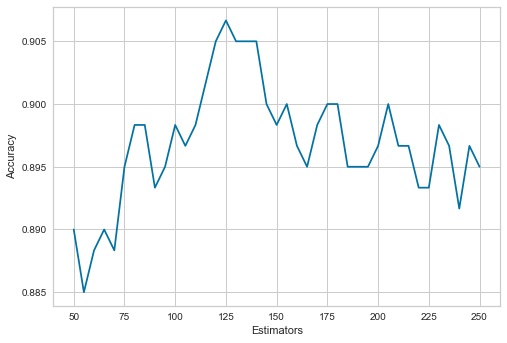

In [21]:
boost = Boost()
scaled_x_train, scaled_x_test = boost.dataPreProcess(x_train,x_test)
df = boost.trainTest(scaled_x_train,scaled_x_test, y_train, y_test)
sns.lineplot(data=df, x="Estimators", y="Accuracy")


In [22]:
best_score, best_params = boost.hyperParameterTuning(scaled_x_train, y_train)
print(best_score, best_params)

0.8742857142857142 {'max_depth': 3, 'n_estimators': 130}


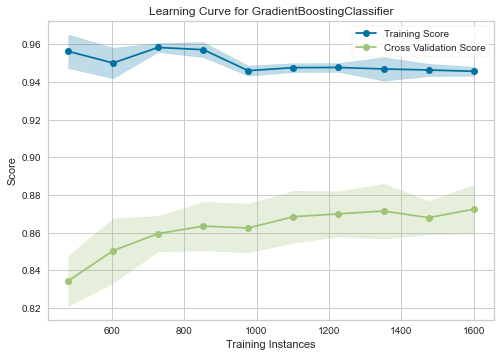

In [23]:
boost_tuned = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_leaf=100)

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    boost_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  